In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense,Conv1D, GlobalMaxPooling1D,BatchNormalization,LeakyReLU
from tensorflow.keras.regularizers import l2
import seaborn as sns

In [3]:
# 1. Load and preprocess the data
print("Loading IMDB dataset...")
max_features = 10000  # Vocabulary size (top 10000 most frequent words)
maxlen = 500  # Maximum sequence length

Loading IMDB dataset...


In [4]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Training data: {len(x_train)} samples")
print(f"Testing data: {len(x_test)} samples")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: 25000 samples
Testing data: 25000 samples


In [5]:
# Examine a sample review
print("\nSample review (encoded):")
print(x_train[0][:10], "...")  # First 10 words of first review


Sample review (encoded):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65] ...


In [6]:
# Decode a sample review to see actual text
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
# Indices 0, 1, and 2 are reserved for padding, start of sequence, and unknown
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print("\nSample review (decoded):")
print(decoded_review[:200], "...")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Sample review (decoded):
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the sa ...


In [7]:
print("\nPadding sequences...")
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
print(f"Training data shape after padding: {x_train.shape}")
print(f"Testing data shape after padding: {x_test.shape}")


Padding sequences...
Training data shape after padding: (25000, 500)
Testing data shape after padding: (25000, 500)


In [8]:
model = Sequential([
    Input(shape=(500,)),
    Embedding(10000, 128),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    LeakyReLU(),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    LeakyReLU(),

    GlobalMaxPooling1D(),

    Dense(64, kernel_regularizer=l2(0.01)),
    LeakyReLU(),
    Dropout(0.6),

    Dense(1, activation='sigmoid')
])


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 500, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,305 (5.14 MB)

 Trainable params: 1,346,049 (5.13 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',     # Watch validation loss
    patience=3,             # Stop after 3 epochs of no improvement
    restore_best_weights=True
)

# Fit the model with EarlyStopping
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 419ms/step - accuracy: 0.5184 - loss: 1.3570 - val_accuracy: 0.7234 - val_loss: 0.8759
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 416ms/step - accuracy: 0.8078 - loss: 0.6692 - val_accuracy: 0.8652 - val_loss: 0.4830
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.9173 - loss: 0.3548 - val_accuracy: 0.8840 - val_loss: 0.3844
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 383ms/step - accuracy: 0.9690 - loss: 0.1775 - val_accuracy: 0.8686 - val_loss: 0.4224
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 384ms/step - accuracy: 0.9868 - loss: 0.1004 - val_accuracy: 0.8736 - val_loss: 0.4227
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 394ms/step - accuracy: 0.9956 - loss: 0.0571 - val_accuracy: 0.8738 - val_loss: 0.4609


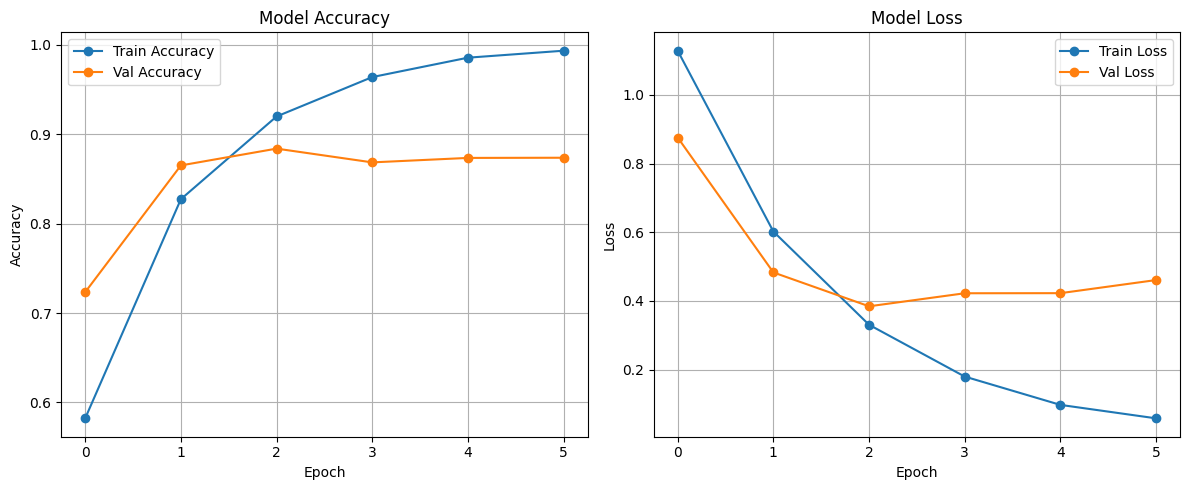

In [12]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


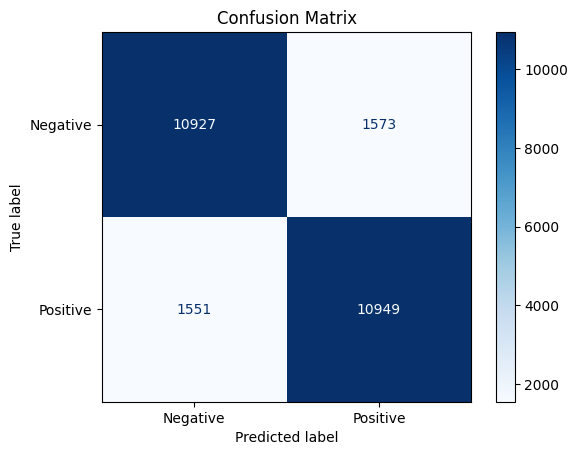

In [13]:
# Predict on test set
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix as heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [14]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87     12500
    Positive       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [15]:
import re
# Preprocess function: remove punctuation and lowercase
def preprocess_review(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    print("\n🧼 Cleaned Review:")
    print(text)
    return text

In [16]:
# Predict sentiment from a review
def predict_sentiment(review_text, threshold=0.5):
    review_text = preprocess_review(review_text)

    # Load word index
    word_index = imdb.get_word_index()

    # Tokenize review
    review_tokens = []
    print("\n🔎 Token Mapping:")
    for word in review_text.split():
        index = word_index.get(word)
        if index and index < max_features:
            token_id = index + 3
        else:
            token_id = 2  # 'unknown' token
        review_tokens.append(token_id)
        print(f"{word:>12} → {token_id}")

    # Pad the review
    review_padded = sequence.pad_sequences([review_tokens], maxlen=maxlen)
    print("\n📦 Padded Review Shape:", review_padded.shape)

    # Predict
    prediction = model.predict(review_padded, verbose=0)[0][0]
    sentiment = "Positive" if prediction > threshold else "Negative"

    # Output
    print(f"\n📊 Predicted Sentiment: {sentiment} (Probability: {prediction:.4f})")
    return prediction, sentiment


In [17]:
raw_review = "This was the bad movie."
prob, sentiment = predict_sentiment(raw_review)



🧼 Cleaned Review:
this was the bad movie

🔎 Token Mapping:
        this → 14
         was → 16
         the → 4
         bad → 78
       movie → 20

📦 Padded Review Shape: (1, 500)

📊 Predicted Sentiment: Negative (Probability: 0.0238)


In [18]:
predict_sentiment("This movie is good.")



🧼 Cleaned Review:
this movie is good

🔎 Token Mapping:
        this → 14
       movie → 20
          is → 9
        good → 52

📦 Padded Review Shape: (1, 500)

📊 Predicted Sentiment: Positive (Probability: 0.7265)


(np.float32(0.7265019), 'Positive')

In [19]:
model.save("sentiment_model.keras")
